In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from scipy.signal import medfilt
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter
# from scipy.optimize import minimize

import csv
import glob
import json
import re
import os
import sys
sys.path.append("/home/nbekareva/TOOLS/utils")
from yield_point_detection import *

# Load Raw Data, Take a Look

### HOW TO
1. Requirements: specify paths to these files before starting your work:
    - *hexag_cristallo_tool.py*
    - *yield_point_detection.py*
    - *json* file with pillar data
2. Enter your data to analyse in the **first cell below**. The rest of the code in this Notebook doesn't need corrections.
3. *NB:* If linear fits of E look wrong in the final plot, consider changing force limits for fits in the variable *to_fit*.

In [ ]:
#  CELL TO MODIFY
json_path = r"/mnt/c/Users/a.walrave/Documents/M2 Internship & PhD/DATA/FemtoTools/2nd_series_pillar_CT_info.json"      # test conditions json
# json_path = r"/mnt/c/Users/a.walrave/Documents/M2 Internship & PhD/DATA/FemtoTools/1st_series_pillar_CT_info.json"
sample = '0001Zn'
pillar = 'P5'
pillar_dimension_type = "initial"       # initial or final msmts, use initial msmts by default
test_id_to_use = -1     # Use last test by default

In [31]:
# 1. Load config file
with open(json_path, 'r') as f:
    config = json.load(f)
datadir = config["samples"][sample]["datadir"]
outdir = config["outdir"]

# 2. Load test numbers
test_ns = config["samples"][sample][pillar]["tests"]

# 3. Test conditions
date = config["date"]
Frame_stiffness = config["Frame_stiffness"]

# 4. Pillar dimensions
dimensions = config["samples"][sample][pillar]["dimensions"][pillar_dimension_type]
h = dimensions["h"]       # um
dtop = dimensions["dtop"] # um
dbott = dimensions["dbott"] # um
rtop = dtop / 2
rbott = dbott / 2

# 4. Set output
outfile = os.path.join(outdir, f'CT_analysis_{sample}.csv')
out_fig = os.path.join(outdir, f'CT_C_{sample}_{pillar}.png')

In [32]:
print(f"Compression test of {date}")
print(f"Loaded configuration for sample {sample}, pillar {pillar}")
print(f"Test numbers: {test_ns}")
print(f'Using test # {test_ns[test_id_to_use]}')
print(f"Using {pillar_dimension_type} dimensions: h={h}µm, dtop={dtop}µm, dbott={dbott}µm")
# print(f"Calculated radii: rtop={rtop}µm, rbott={rbott}µm")

Compression test of 2025-02-26
Loaded configuration for sample 0001Zn, pillar P5
Test numbers: [32, 35, 38, 42, 45, 48]
Using test # 48
Using initial dimensions: h=2.51µm, dtop=0.92µm, dbott=1.62µm


In [33]:
# load dir
os.chdir(f'{datadir}')
print(os.getcwd())
files = " ".join(glob.glob("*.txt"))
print(files)

/mnt/c/Users/a.walrave/Documents/M2 Internship & PhD/DATA/FemtoTools/CT_C_0001Zn_2025-02-26,10h43m44s/Data_2025-02-26,18h53m52s
2025-02-26_12-52-37_0_0.txt 2025-02-26_13-15-38_1_0.txt 2025-02-26_13-17-25_2_0.txt 2025-02-26_13-19-39_3_0.txt 2025-02-26_13-22-16_4_0.txt 2025-02-26_13-25-41_5_0.txt 2025-02-26_13-40-19_6_0.txt 2025-02-26_13-42-25_7_0.txt 2025-02-26_13-43-51_8_0_Aborted.txt 2025-02-26_14-01-05_9_0.txt 2025-02-26_14-04-56_10_0.txt 2025-02-26_14-05-46_11_0.txt 2025-02-26_14-19-45_12_0.txt 2025-02-26_14-20-37_13_0.txt 2025-02-26_14-21-08_14_0_Aborted.txt 2025-02-26_14-35-41_15_0.txt 2025-02-26_14-37-00_16_0_Aborted.txt 2025-02-26_14-43-13_17_0.txt 2025-02-26_14-44-16_18_0.txt 2025-02-26_14-46-03_19_0.txt 2025-02-26_14-46-49_20_0_Aborted.txt 2025-02-26_15-11-38_21_0.txt 2025-02-26_15-12-34_22_0.txt 2025-02-26_15-13-28_23_0_Aborted.txt 2025-02-26_15-33-01_24_0.txt 2025-02-26_15-34-57_25_0.txt 2025-02-26_15-55-41_26_0.txt 2025-02-26_15-56-12_27_0_Aborted.txt 2025-02-26_15-59-40_28

In [34]:
# load test files
test_names = [re.search(fr"[\d\-_]{{19}}_{n}_0(_Aborted){{0,1}}.txt", files).group(0) for n in test_ns]
print(f'Compression tests for sample {sample}, pillar {pillar}, date {date}: \n{test_names}')

Compression tests for sample 0001Zn, pillar P5, date 2025-02-26: 
['2025-02-26_16-04-06_32_0.txt', '2025-02-26_16-31-50_35_0_Aborted.txt', '2025-02-26_17-03-46_38_0_Aborted.txt', '2025-02-26_17-30-45_42_0_Aborted.txt', '2025-02-26_17-56-27_45_0_Aborted.txt', '2025-02-26_18-23-37_48_0_Aborted.txt']


In [ ]:
# Load chosen test
test_to_load = test_names[test_id_to_use]
data = pd.read_csv(test_to_load, skiprows=(0,1,3), sep='\t', 
                   encoding='unicode_escape', low_memory=False)
data.head()

Index(['Phase', 'Displacement', 'Time', 'Pos X', 'Piezo X', 'Force A',
       'Sample Displace'],
      dtype='object')


,Phase,Displacement,Time,Pos X,Piezo X,Force A,Sample Displace
0,1.0,0.005647,27721.813,24378.959,-0.000287,-0.196654,-0.010108
1,1.0,0.005508,27721.815,24378.959,-0.000426,-0.160429,-0.010247
2,1.0,0.005030,27721.817,24378.959,-0.000904,-0.101728,-0.010725
3,1.0,0.005474,27721.819,24378.959,-0.000460,0.171333,-0.010282
4,1.0,0.004851,27721.821,24378.959,-0.001083,0.028537,-0.010904


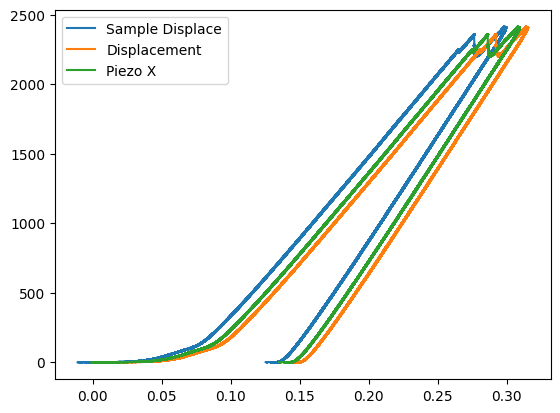

In [36]:
# # check col content: ['Displacement', 'Sample Displace', 'PosX', 'PiezoX']
plt.figure()
force = data.loc[:, 'Force A'].to_numpy(dtype=float)
for col in ['Sample Displace', 'Displacement', 'Piezo X']:
    x = data.loc[:, col].to_numpy(dtype=float)
    plt.plot(x, force, label=col)
plt.legend()
plt.show()

# Data Treatment

In [39]:
# def find_curve_start(x, y):    # to improve based on force
# #     noise = x[(-0.3 < x) & (x < -0.1)].std()
#     idx = x[x >= 0].index[0]
#     print(idx, x[idx])
#     print(x[x > x[idx]])
    
# find_curve_start(data['Sample Displace'], data['Force A'])

In [ ]:
def get_nu_E_bulk():
    from hexag_cristallo_tool import Wurtzite
    crystal = Wurtzite(3.25, 5.2)
    E, nu = crystal.E_nu_bulk()
    print(f"E: {E:.2f} GPa nu: {nu:.2f}")
    return nu, E

In [ ]:
# Stripping off useless data
data = data[data['Sample Displace'] >= 0]
data = data.loc[:, ['Phase', 'Force A', 'Sample Displace']].astype(float)
data.reset_index(inplace=True)

# calculating true displacement
# 1. Sneddon corrections
nu, E = get_nu_E_bulk()        # GPa
data['h_Sneddon_bott'] = (1 - nu**2) / (2*E * rbott) * data['Force A'] * 1e-3    # um

nu, E = 0.07, 1143                        # diamond
data['h_Sneddon_top'] = (1 - nu**2) / (2*E * rtop) * data['Force A'] * 1e-3    # um

# 2. Frame compliance --> result
data['trueD'] = data['Sample Displace'] - data['Force A'] / Frame_stiffness - \
                data['h_Sneddon_bott'] - data['h_Sneddon_top']

data['Strain'] = data['trueD'] / h      # unitless
data['Stress'] = data['Force A'] / (1/2 * np.pi * (rtop**2 + rbott**2))   # 1e-6 N / 1e-12 m = 1e6 Pa
# data['Stress'] = savgol_filter(data['StressRaw'], 1000, 5)

Bulk moduli for substrate Sneddon:
Voigt: BV 131.40, GV 43.88
Reuss: BR 108.59, GR 41.80
E: 114.85 GPa nu: 0.34


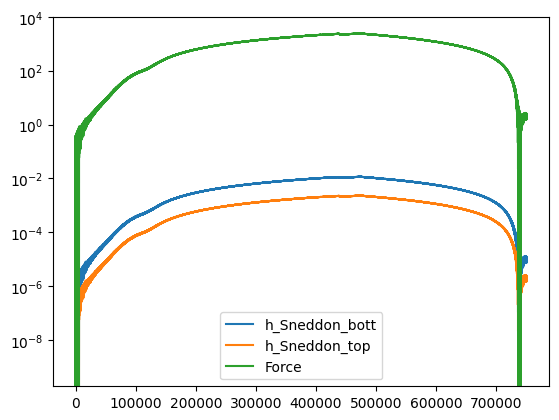

In [ ]:
# visual check Sneddon
plt.figure()
plt.plot(data['h_Sneddon_bott'], label='h_Sneddon_bott')
plt.plot(data['h_Sneddon_top'], label='h_Sneddon_top')
plt.plot(data['Force A'], label='Force')
plt.semilogy()
plt.legend()
plt.show()
# proportional, so OK !

In [44]:
# # Noise
# # data['SampleDisplacementSmooth'] = savgol_filter(data['SampleDisplacement'], 1000, 5)
# # df = data[data['SampleDisplacementSmooth'] >= 0]
# data['StrainSmooth'] = savgol_filter(data['Strain'], 1000, 5)
# data = data[data['SampleDisplacement'] >= 0]
# data['StressSmooth'] = savgol_filter(data['Stress'], 1000, 5)

# plt.figure()
# for phase in data['Phase'].unique():
#     cond = data['Phase'] == phase
#     plt.scatter(data.loc[cond, 'Strain'], data.loc[cond, 'Stress'], s=0.1, alpha=0.5, label=f'Phase {phase}')
#     plt.scatter(data.loc[cond, 'StrainSmooth'], data.loc[cond, 'StressSmooth'], s=0.1, alpha=0.5, label=f'Smooth {phase}')
# plt.xlabel('Strain')
# plt.ylabel('Stress (MPa)')
# plt.xlim([-0.03, 0.03])
# plt.ylim([-1, 3])
# # plt.legend()
# plt.show()

In [45]:
# Sticking together incremental tests - uncomment if necessary - TO DO


In [46]:
# Linear fit: returns x, y fitted vectors, slope value and x_int (intersection with x-axis)
def lin_fit(x, y):
    x0, x1 = x.values[0], x.values[-1]
    p1, p0 = np.polyfit(x, y, deg=1)
    x_fitted = np.linspace(x0, x1, 10)
    y_fitted = p0 + p1 * x_fitted
    x_int = -p0 / p1
    return x_fitted, y_fitted, p1, x_int

In [47]:
# Young's module at withdrawal (wd)
fmax = data.loc[data['Phase'] == 4, 'Force A'].max()
to_fit = (data['Phase'] == 4) & (0.4*fmax < data['Force A']) & (data['Force A'] < 0.9*fmax)
# E, E0 = np.polyfit(data.loc[to_fit_lin, 'Strain'], data.loc[to_fit_lin, 'Stress'], deg=1)
# lin_fit = E0 + E*data.loc[to_fit_lin, 'Strain']
epsilon_wd, sigma_wd, E_wd, eps_fin = lin_fit(data.loc[to_fit, 'Strain'], data.loc[to_fit, 'Stress'])

print(f'Max force at withdrawal: {fmax:.2f} uN')
# print('Linear fit coefs:', E0, E)
print(f"Young's module: {E_wd:,.0f} MPa")
print(f"Max plastic deformation, eps_fin: {eps_fin:.3f}")

Max force at withdrawal: 2412.99 uN
Young's module: 769,039 MPa
Max plastic deformation, eps_fin: 0.057


In [48]:
# # Curve start polyfit
# to_fit_start = (data['Phase'] == 1) & (0.08*fmax < data['ForceA']) & (data['ForceA'] < 0.1*fmax)
# p3, p2, p1, p0 = np.polyfit(data.loc[to_fit_start, 'Strain'], data.loc[to_fit_start, 'Stress'], deg=3)
# x = data.loc[to_fit_start, 'Strain']
# start_fit = p0 + p1 * x + p2 * x**2 + p3 * x**3
# p3, p2, p1, p0

In [49]:
# Young's module at compression (ct) + epsilon_zero
to_fit = (data['Phase'] == 1) & (0.4*fmax < data['Force A']) & (data['Force A'] < 0.9*fmax)
epsilon_ct, sigma_ct, E_ct, eps0 = lin_fit(data.loc[to_fit, 'Strain'], data.loc[to_fit, 'Stress'])

print(f"Strain linear interpolation at the start, eps0: {eps0}")

Strain linear interpolation at the start, eps0: 0.02979093478800203


Noise level: 0.0076, Applied smoothing: 0.50
No clear plastic event detected, using bilinear fit result instead


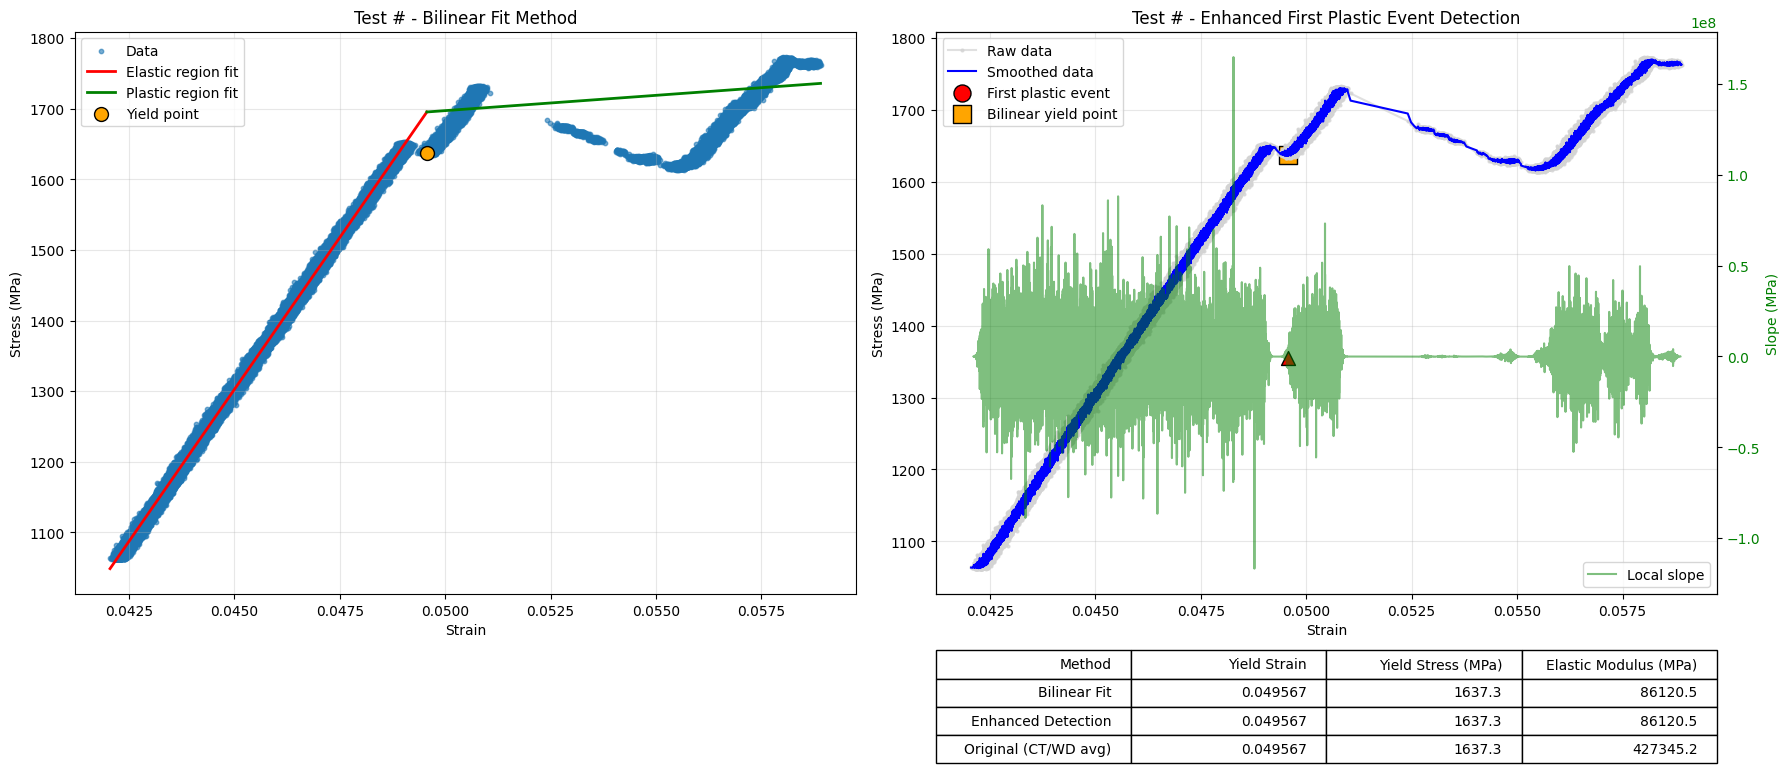

Yield strength: 0.019775623779364183, 1637.3225899138497 MPa
Total plastic deformation: 0.027163128335592958


In [ ]:
# Yield point detection
# to_search = (data['Phase'] == 1) & (data['Force A'] > 0)
to_search = (data['Phase'] == 1) & (0.6*fmax < data['Force A']) & (data['Force A'] < 1.1*fmax)

# 1. inflection pts - OLD METHOD
# _, _, _, inflection_pts = find_inflection_points(
#     data.loc[to_search, 'Strain'], 
#     data.loc[to_search, 'Stress'],
#     E_wd, sampling_freq=250, visualise=True
# )

# 2. Bilinear fit result for comparison
bilinear_idx, bilinear_strain, bilinear_stress, E_bilinear = bilinear_fit_yield_point(
    data.loc[to_search, 'Strain'], 
    data.loc[to_search, 'Stress'],
    min_points=15
)

# 3. Enhanced detection
sigma_y_id, eps_y, sigma_y, E_enhanced = detect_first_plastic_event(
    data.loc[to_search, 'Strain'], 
    data.loc[to_search, 'Stress'],
    window_size=50,
    threshold_factor=50,  # Adjust based on your material's behavior
    smoothing_factor=1.0   # Adjust based on noise level
)

# Calculate elastic and plastic deformation
eps_el = eps_y - eps0
eps_pl = eps_fin - eps0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot bilinear fit result
plot_bilinear_fit(data.loc[to_search, 'Strain'], data.loc[to_search, 'Stress'], 
                    bilinear_idx, ax=ax1)
ax1.set_title(f"Test # - Bilinear Fit Method")

# Plot enhanced detection result
visualize_event_detection(data.loc[to_search, 'Strain'], data.loc[to_search, 'Stress'], 
                            sigma_y_id, bilinear_idx=bilinear_idx, ax=ax2)
ax2.set_title(f"Test # - Enhanced First Plastic Event Detection")

# Add a table comparing the results
table_data = [
    ['Method', 'Yield Strain', 'Yield Stress (MPa)', 'Elastic Modulus (MPa)'],
    ['Bilinear Fit', f'{bilinear_strain:.6f}', f'{bilinear_stress:.1f}', f'{E_bilinear:.1f}'],
    ['Enhanced Detection', f'{eps_y:.6f}', f'{sigma_y:.1f}', f'{E_enhanced:.1f}'],
    ['Original (CT/WD avg)', f'{eps_y:.6f}', f'{sigma_y:.1f}', f'{(E_ct+E_wd)/2:.1f}']
]

table = ax2.table(cellText=table_data, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
# plt.savefig(config['out_fig'], dpi=300)
plt.show()

print(f'Yield strength: {eps_el:.3f}, {sigma_y:.0f} MPa')
print(f'Total plastic deformation: {eps_pl:.3f}')

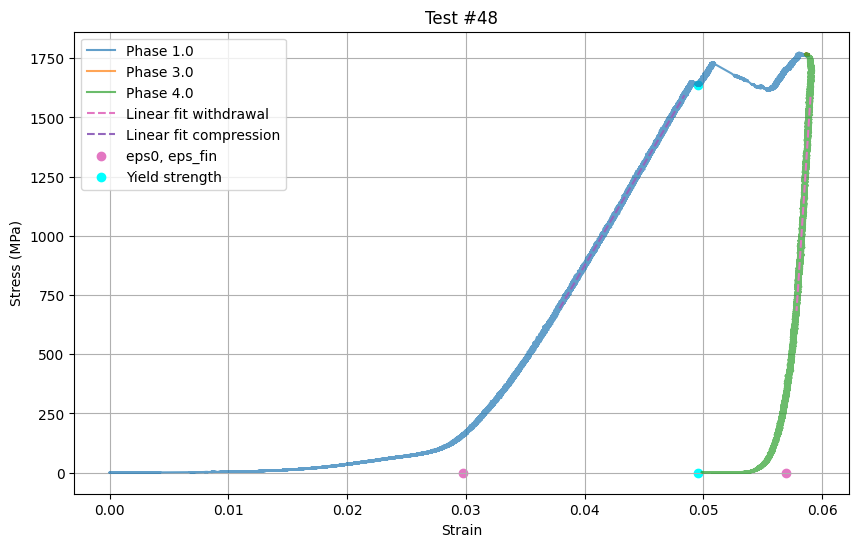

In [51]:
# Final Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data points by phase
for phase in data['Phase'].unique():
    cond = data['Phase'] == phase
    ax.plot(data.loc[cond, 'Strain'], data.loc[cond, 'Stress'], 
                alpha=0.7, label=f'Phase {phase}')

# Plot fits and important points
ax.plot(epsilon_wd, sigma_wd, "--", c='tab:pink', label='Linear fit withdrawal')
ax.plot(epsilon_ct, sigma_ct, "--", c='tab:purple', label='Linear fit compression')
ax.scatter([eps0, eps_fin], [0, 0], c='tab:pink', label='eps0, eps_fin')

# Plot flexure points if they exist
# if len(inflection_pts) > 0 and all(i in data.index for i in inflection_pts):
#     ax.scatter(data.loc[inflection_pts, 'Strain'], data.loc[inflection_pts, 'Stress'], c='y')

# Plot yield strength
ax.scatter([eps_y, eps_y], [sigma_y, 0], c='cyan', label='Yield strength')

# Format plot
ax.set_xlabel('Strain')
ax.set_ylabel('Stress (MPa)')
ax.set_title(f"Test #{test_ns[test_id_to_use]}")
ax.grid()
ax.legend()

In [52]:
# Sumup
print(f"Sample {sample}, pillar {pillar}:\n")
print(f"Young's module: withdrawal {E_wd:,.0f} MPa, compression {E_ct:,.0f} MPa, mean {(E_wd+E_ct)/2:,.0f}")
print(f"Max plastic deformation, eps_fin:\t {eps_fin:.3f}")
print(f"Max elastic deformation, eps_el:\t {eps_el:.3f}")
print(f'Yield strength:\t\t\t\t {eps_y:.3f}, {sigma_y:,.0f} MPa')
print(f'Total plastic deformation:\t\t {eps_pl:.3f}')

Sample 0001Zn, pillar P5:

Young's module: withdrawal 769,039 MPa, compression 85,652 MPa, mean 427,345
Max plastic deformation, eps_fin:	 0.057
Max elastic deformation, eps_el:	 0.020
Yield strength:				 0.050, 1,637 MPa
Total plastic deformation:		 0.027


In [53]:
# write data
# with open(outfile, 'a', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',')    # quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     spamwriter.writerow([sample, pillar, E_wd, E_ct, eps0, eps_fin, eps_el, eps_pl, eps_y, sigma_y])